In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla, Reverse_kernel_sampling
from target import GMM_target, GMM_target2, Funnel, Gaussian_target, Banana
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import pdb

In [2]:
args = get_args()

In [3]:
target = Banana(args)

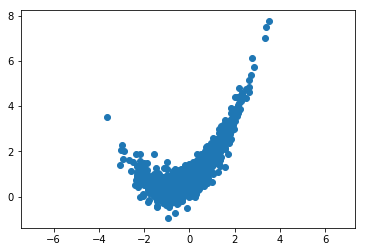

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
## Here we fix K
args.n_steps = args.K # how many samples to use
args.n_warmup = 0 # num of first samples to refuse

args.n_chains = 10 # how many chains to model
args.data_dim = 2

limit = 7

In [6]:
vanilla_kernel = HMC_vanilla(args)

## Vanilla HMC

In [7]:
q_new = args.std_normal.sample((args.n_chains, args.z_dim))
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 235.82it/s]

Now we are running warmup!
Now we are sampling!


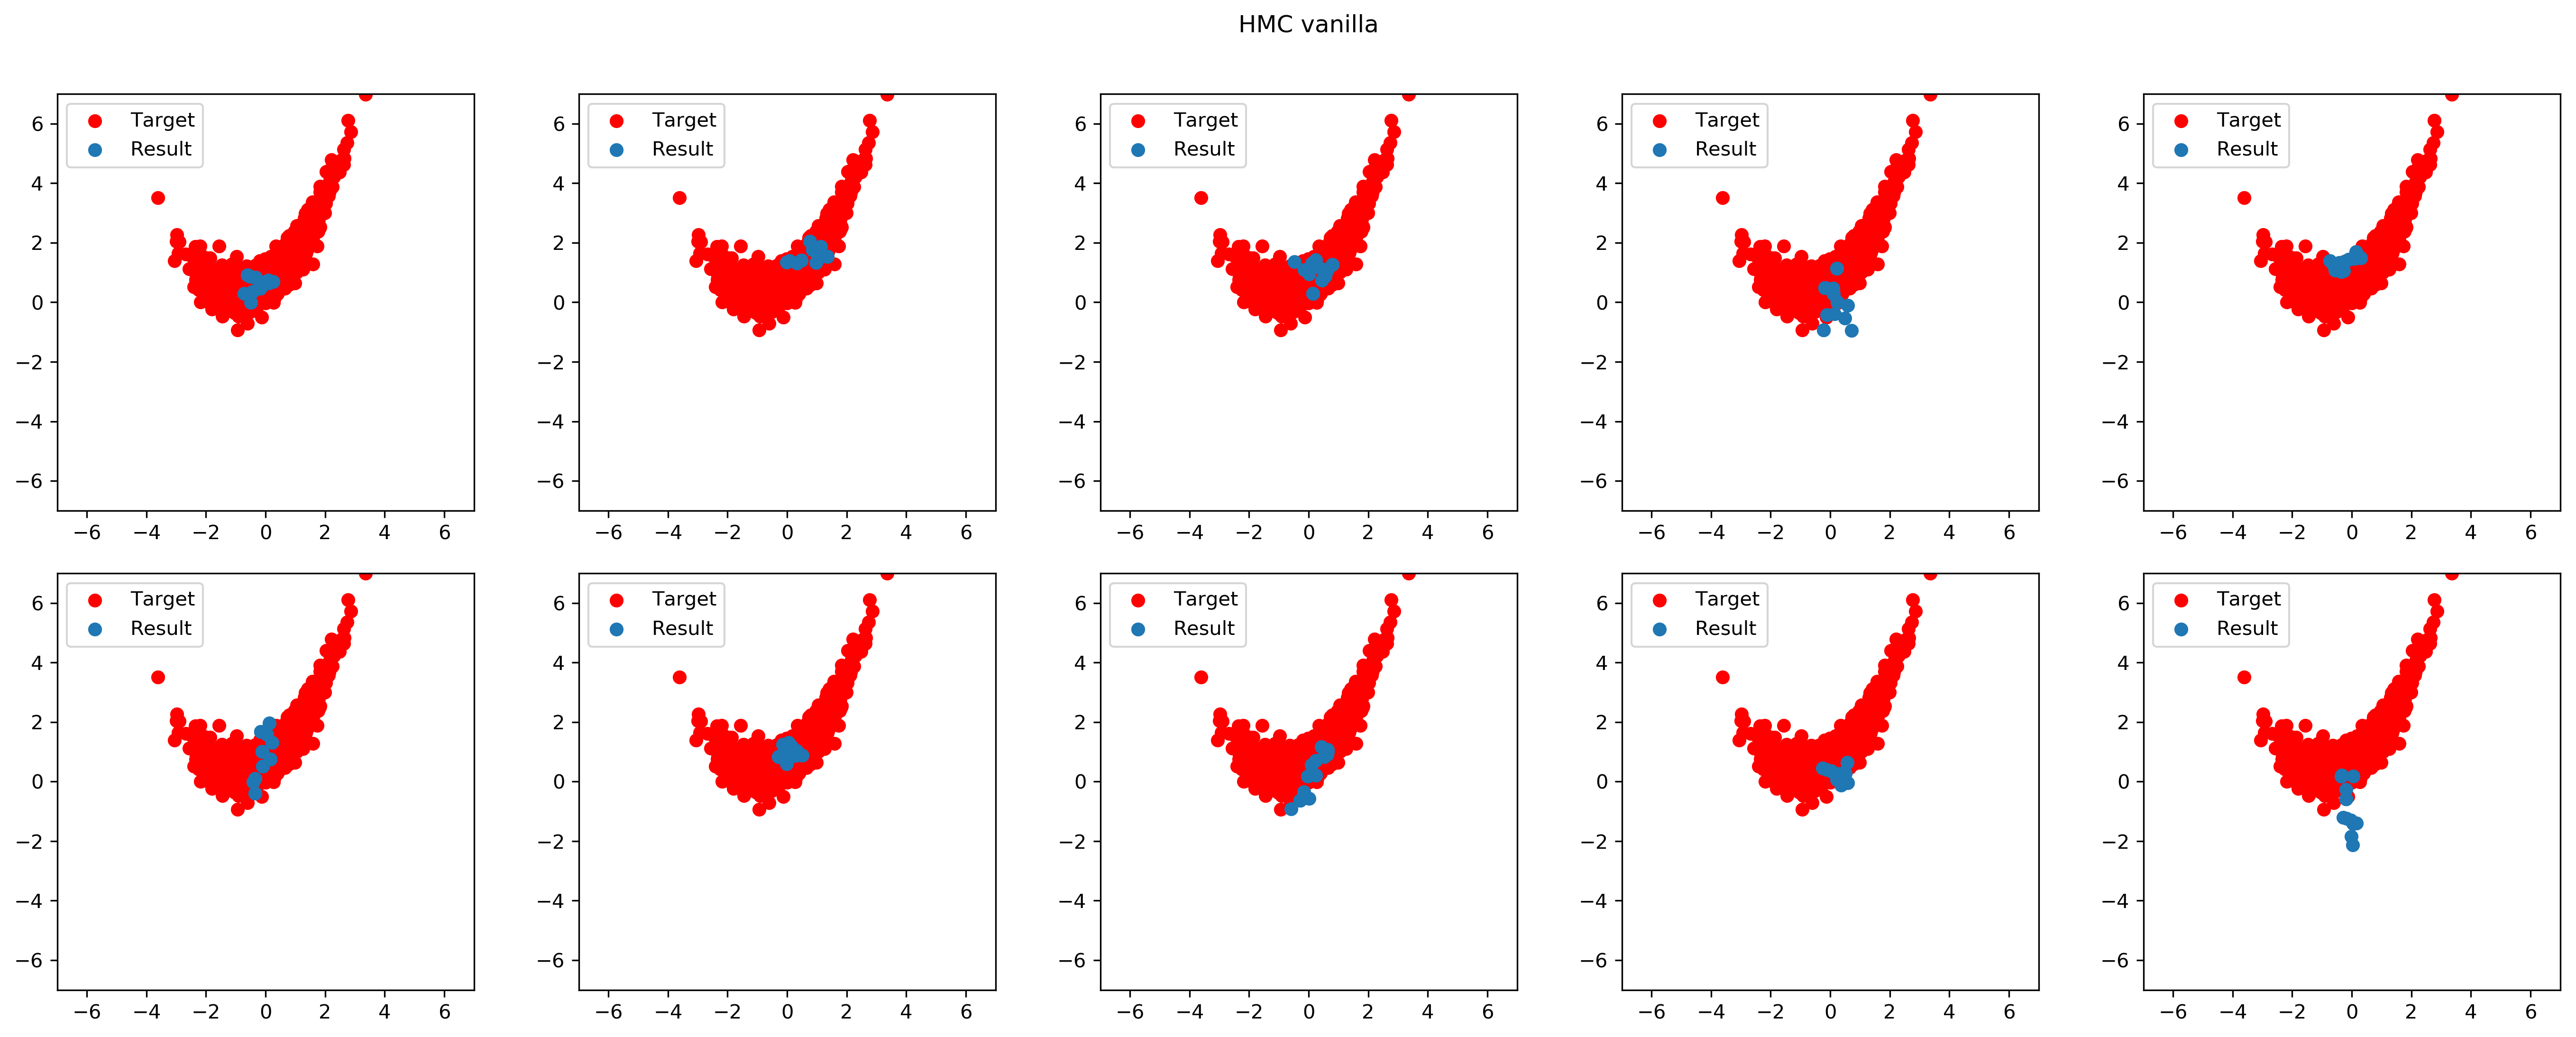

In [8]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

## Hoffman HMC

In [9]:
##### Minimize KL first

mu_init_hoff = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_hoff = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))
optimizer = torch.optim.Adam(params=[mu_init_hoff, sigma_init_hoff])

init_distr = torch.distributions.Normal(loc=mu_init_hoff, scale=nn.functional.softplus(sigma_init_hoff))
for i in tqdm(range(20000)):
#     pdb.set_trace()
    q_init = init_distr.sample((500, ))
    current_kl = init_distr.log_prob(q_init).sum(1) - target.get_logdensity(z=q_init)
    torch.mean(current_kl).backward() ## minimize KL
    optimizer.step()
    optimizer.zero_grad()
    init_distr = torch.distributions.Normal(loc=mu_init_hoff, scale=nn.functional.softplus(sigma_init_hoff))
    if i % 2000 == 0:
        print(current_kl.mean().cpu().detach().numpy())

  1%|          | 201/20000 [00:00<00:20, 958.90it/s]

22.482777


 11%|█         | 2172/20000 [00:01<00:14, 1205.66it/s]

16.042658


 21%|██        | 4192/20000 [00:03<00:12, 1227.14it/s]

20.037146


 31%|███       | 6197/20000 [00:05<00:11, 1232.29it/s]

18.504826


 41%|████      | 8209/20000 [00:06<00:09, 1224.12it/s]

16.948183


 51%|█████     | 10247/20000 [00:08<00:07, 1276.08it/s]

15.530971


 61%|██████    | 12166/20000 [00:09<00:06, 1277.30it/s]

17.891594


 71%|███████   | 14193/20000 [00:11<00:04, 1265.34it/s]

15.019027


 81%|████████▏ | 16257/20000 [00:13<00:02, 1287.56it/s]

13.33344


 91%|█████████ | 18185/20000 [00:14<00:01, 1289.27it/s]

14.543542


100%|██████████| 20000/20000 [00:16<00:00, 1232.54it/s]


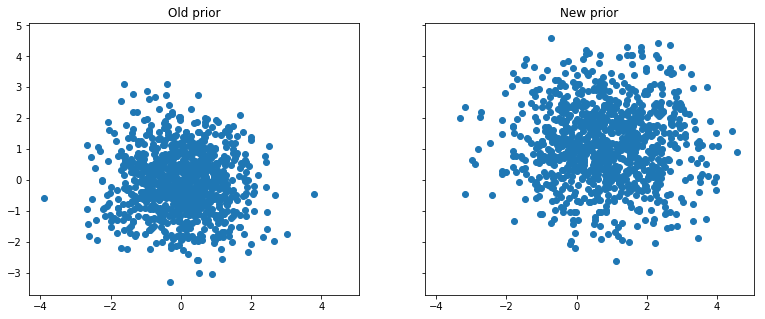

In [10]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

mu_init_hoff.requires_grad_(False)
sigma_init_hoff.requires_grad_(False)
prior_new = mu_init_hoff + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_hoff)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [11]:
### Then run HMC (without warmup) of length K

q_new = mu_init_hoff + args.std_normal.sample((args.n_chains, args.z_dim)) * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_hoffman = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_hoffman[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 312.09it/s]

Now we are running warmup!
Now we are sampling!


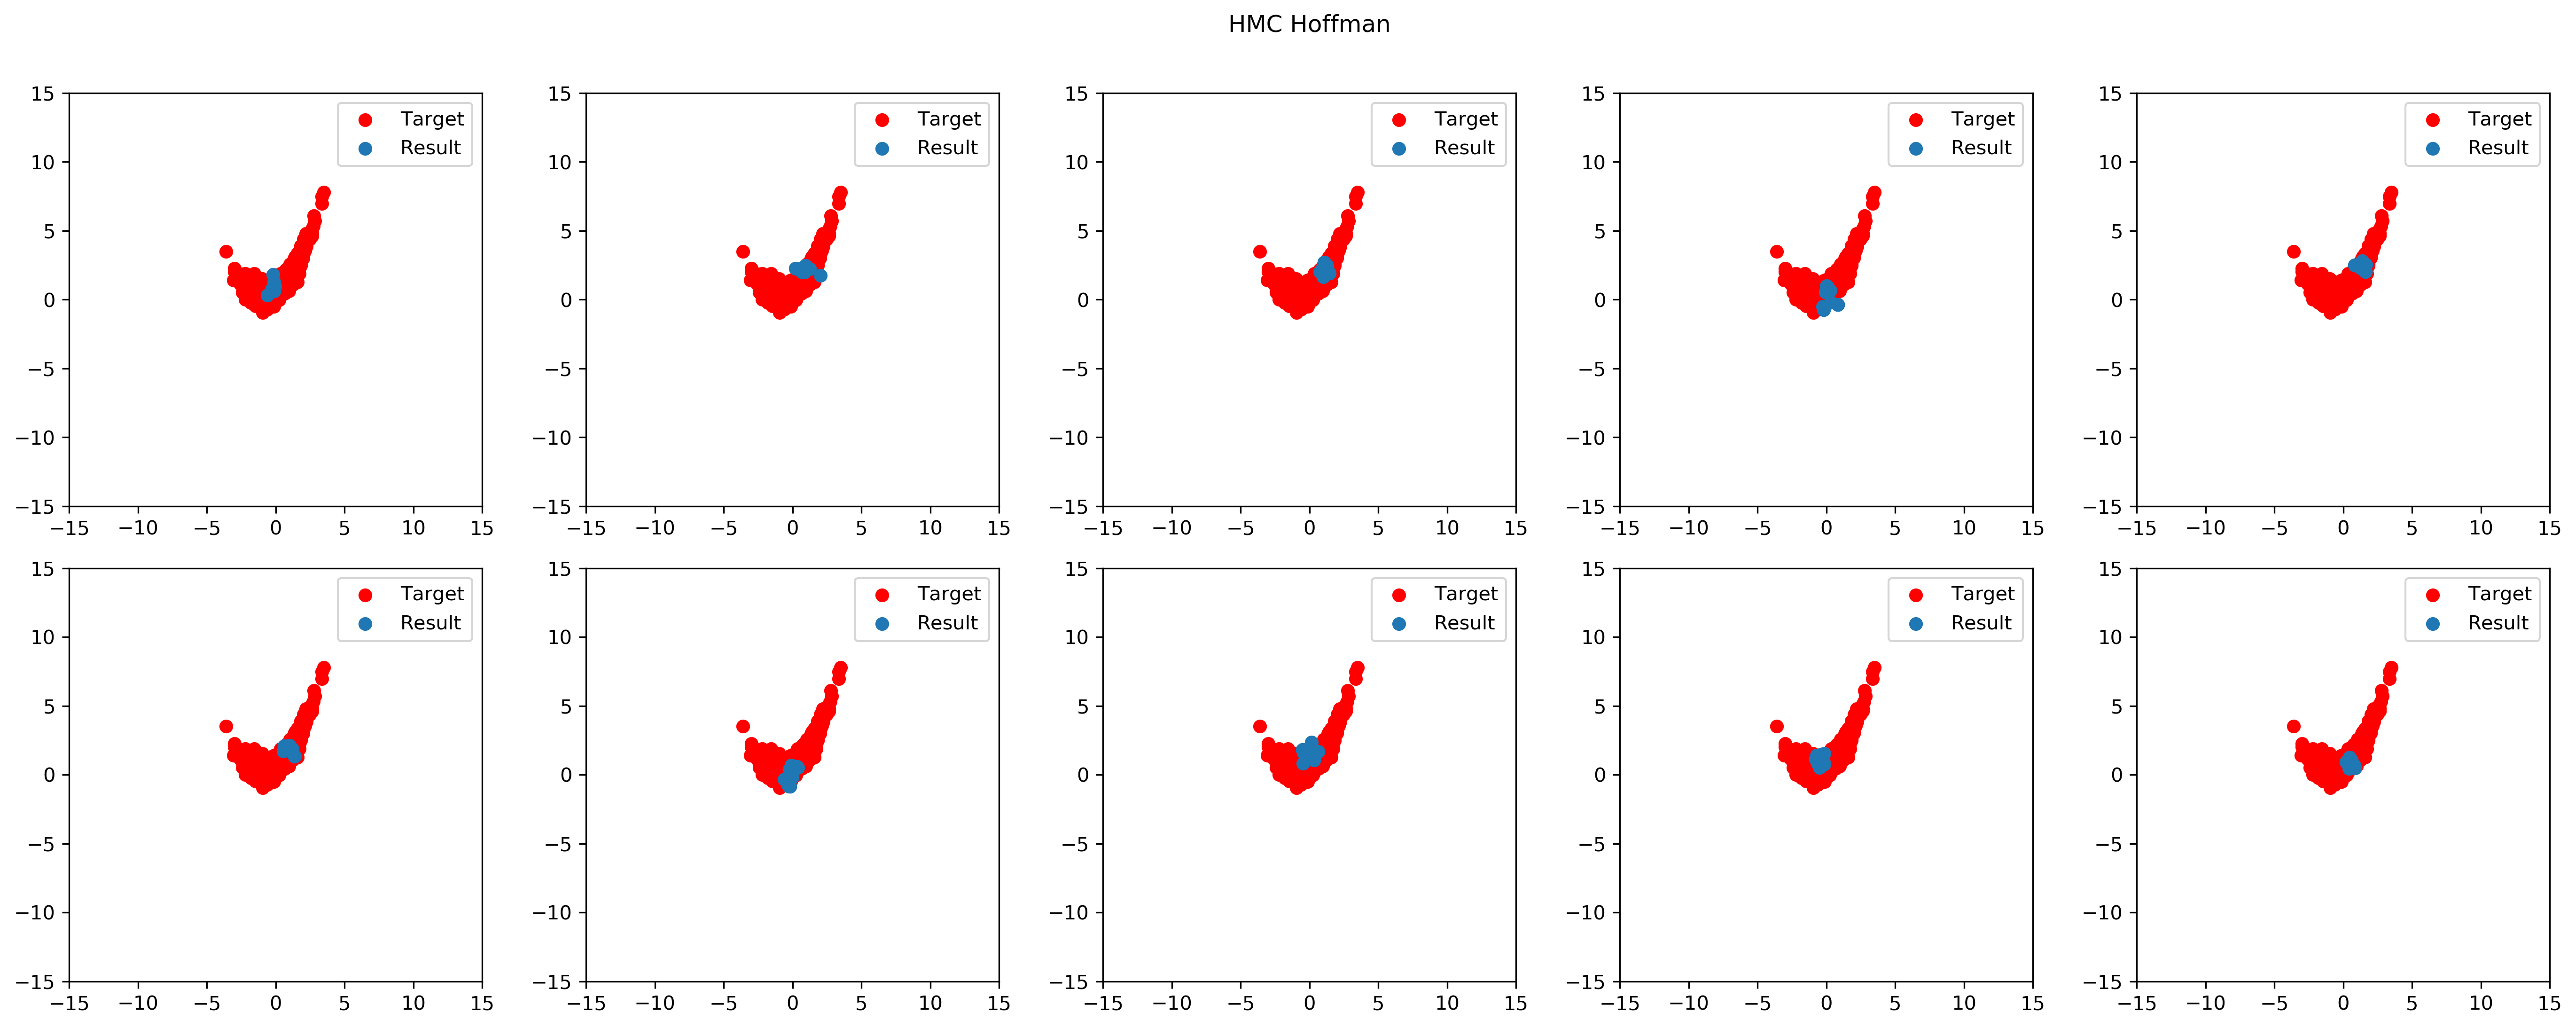

In [12]:
### Plot received chains

limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC Hoffman')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_hoffman[:, chain_num, 0].cpu(), samples_hoffman[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

## Ours HMC

In [39]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
    our_kernel_best = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    our_kernel_best = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
        
for p in transitions.parameters():
    transitions.requires_grad_(False)
    
mu_init = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))

params = list(transitions.parameters()) + list(reverse_params) + [mu_init, sigma_init]

optimizer = torch.optim.Adam(params=params)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

##### Training















  0%|          | 0/5000 [00:00<?, ?it/s]

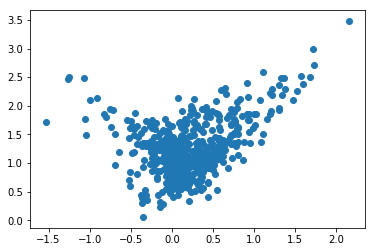















  0%|          | 1/5000 [00:00<18:53,  4.41it/s]













  0%|          | 3/5000 [00:00<14:57,  5.57it/s]

Current lr:  0.001
On batch number 0 ELBO is -9.545140266418457
On batch number 0 Best ELBO is -inf
















  0%|          | 5/5000 [00:00<12:17,  6.77it/s]













  0%|          | 7/5000 [00:00<10:27,  7.95it/s]













  0%|          | 9/5000 [00:00<09:08,  9.10it/s]













  0%|          | 11/5000 [00:00<08:09, 10.18it/s]













  0%|          | 13/5000 [00:01<07:38, 10.88it/s]













  0%|          | 15/5000 [00:01<07:15, 11.43it/s]













  0%|          | 17/5000 [00:01<06:50, 12.15it/s]













  0%|          | 19/5000 [00:01<06:31, 12.74it/s]













  0%|          | 21/5000 [00:01<06:19, 13.11it/s]













  0%|          | 23/5000 [00:01<06:17, 13.18it/s]













  0%|          | 25/5000 [00:01<06:07, 13.54it/s]













  1%|          | 27/5000 [00:02<06:07, 13.54it/s]













  1%|          | 29/5000 [00:02<06:00, 13.80it/s]













  1%|          | 31/5000 [00:02<06:07, 13.53it/s]













  1%|          | 33/5000 [00:02<06:06, 13.57it/s]













  1%|          | 35/5000 [00:02<06:05, 13.60

  3%|▎         | 159/5000 [00:11<05:55, 13.61it/s]













  3%|▎         | 161/5000 [00:11<05:51, 13.75it/s]













  3%|▎         | 163/5000 [00:12<05:46, 13.94it/s]













  3%|▎         | 165/5000 [00:12<05:43, 14.07it/s]













  3%|▎         | 167/5000 [00:12<05:42, 14.11it/s]













  3%|▎         | 169/5000 [00:12<05:40, 14.18it/s]













  3%|▎         | 171/5000 [00:12<05:39, 14.21it/s]













  3%|▎         | 173/5000 [00:12<05:39, 14.23it/s]













  4%|▎         | 175/5000 [00:12<05:58, 13.46it/s]













  4%|▎         | 177/5000 [00:13<06:26, 12.48it/s]













  4%|▎         | 179/5000 [00:13<06:18, 12.74it/s]













  4%|▎         | 181/5000 [00:13<06:11, 12.97it/s]













  4%|▎         | 183/5000 [00:13<06:19, 12.69it/s]













  4%|▎         | 185/5000 [00:13<06:05, 13.16it/s]













  4%|▎         | 187/5000 [00:13<06:04, 13.21it/s]













  4%|▍         | 189/5000 [00:13<06:01, 

  6%|▋         | 313/5000 [00:22<05:23, 14.48it/s]













  6%|▋         | 315/5000 [00:22<05:25, 14.41it/s]













  6%|▋         | 317/5000 [00:23<05:25, 14.40it/s]













  6%|▋         | 319/5000 [00:23<05:26, 14.35it/s]













  6%|▋         | 321/5000 [00:23<05:27, 14.27it/s]













  6%|▋         | 323/5000 [00:23<05:28, 14.23it/s]













  6%|▋         | 325/5000 [00:23<05:40, 13.73it/s]













  7%|▋         | 327/5000 [00:23<05:40, 13.71it/s]













  7%|▋         | 329/5000 [00:23<05:35, 13.92it/s]













  7%|▋         | 331/5000 [00:24<05:31, 14.06it/s]













  7%|▋         | 333/5000 [00:24<05:29, 14.14it/s]













  7%|▋         | 335/5000 [00:24<05:25, 14.32it/s]













  7%|▋         | 337/5000 [00:24<05:24, 14.35it/s]













  7%|▋         | 339/5000 [00:24<05:22, 14.43it/s]













  7%|▋         | 341/5000 [00:24<05:22, 14.45it/s]













  7%|▋         | 343/5000 [00:24<05:24, 

  9%|▉         | 467/5000 [00:33<05:12, 14.48it/s]













  9%|▉         | 469/5000 [00:33<05:13, 14.45it/s]













  9%|▉         | 471/5000 [00:33<05:14, 14.39it/s]













  9%|▉         | 473/5000 [00:33<05:14, 14.42it/s]













 10%|▉         | 475/5000 [00:34<05:14, 14.41it/s]













 10%|▉         | 477/5000 [00:34<05:15, 14.35it/s]













 10%|▉         | 479/5000 [00:34<05:29, 13.73it/s]













 10%|▉         | 481/5000 [00:34<05:25, 13.88it/s]













 10%|▉         | 483/5000 [00:34<05:22, 14.01it/s]













 10%|▉         | 485/5000 [00:34<05:21, 14.06it/s]













 10%|▉         | 487/5000 [00:34<05:19, 14.13it/s]













 10%|▉         | 489/5000 [00:35<05:15, 14.28it/s]













 10%|▉         | 491/5000 [00:35<05:18, 14.18it/s]













 10%|▉         | 493/5000 [00:35<05:19, 14.11it/s]













 10%|▉         | 495/5000 [00:35<05:14, 14.31it/s]













 10%|▉         | 497/5000 [00:35<05:12, 

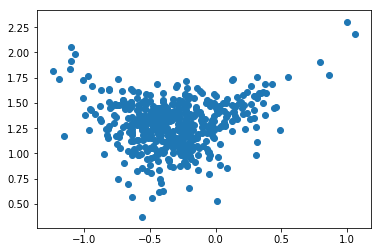















 10%|█         | 501/5000 [00:36<06:32, 11.46it/s]













 10%|█         | 503/5000 [00:36<06:07, 12.23it/s]

Current lr:  0.0008100000000000001
On batch number 500 ELBO is -8.251455307006836
On batch number 500 Best ELBO is -8.217244148254395
















 10%|█         | 505/5000 [00:36<05:52, 12.76it/s]













 10%|█         | 507/5000 [00:36<05:43, 13.08it/s]













 10%|█         | 509/5000 [00:36<05:39, 13.24it/s]













 10%|█         | 511/5000 [00:36<05:38, 13.26it/s]













 10%|█         | 513/5000 [00:36<05:39, 13.22it/s]













 10%|█         | 515/5000 [00:37<05:33, 13.43it/s]













 10%|█         | 517/5000 [00:37<05:32, 13.49it/s]













 10%|█         | 519/5000 [00:37<05:30, 13.56it/s]













 10%|█         | 521/5000 [00:37<05:23, 13.86it/s]













 10%|█         | 523/5000 [00:37<05:21, 13.93it/s]













 10%|█         | 525/5000 [00:37<05:21, 13.90it/s]













 11%|█         | 527/5000 [00:37<05:17, 14.09it/s]













 11%|█         | 529/5000 [00:38<05:39, 13.16it/s]













 11%|█         | 531/5000 [00:38<05:31, 13.47it/s]













 11%|█         | 533/5000 [00:38<05:25, 13.72it/s]













 11%|█         | 535/5000 

 13%|█▎        | 659/5000 [00:47<05:12, 13.90it/s]













 13%|█▎        | 661/5000 [00:47<05:14, 13.78it/s]













 13%|█▎        | 663/5000 [00:47<05:15, 13.73it/s]













 13%|█▎        | 665/5000 [00:47<05:10, 13.98it/s]













 13%|█▎        | 667/5000 [00:47<05:12, 13.86it/s]













 13%|█▎        | 669/5000 [00:48<05:10, 13.94it/s]













 13%|█▎        | 671/5000 [00:48<05:08, 14.04it/s]













 13%|█▎        | 673/5000 [00:48<05:08, 14.04it/s]













 14%|█▎        | 675/5000 [00:48<05:13, 13.79it/s]













 14%|█▎        | 677/5000 [00:48<05:11, 13.89it/s]













 14%|█▎        | 679/5000 [00:48<05:08, 14.02it/s]













 14%|█▎        | 681/5000 [00:48<05:03, 14.22it/s]













 14%|█▎        | 683/5000 [00:49<05:05, 14.12it/s]













 14%|█▎        | 685/5000 [00:49<05:02, 14.26it/s]













 14%|█▎        | 687/5000 [00:49<05:03, 14.20it/s]













 14%|█▍        | 689/5000 [00:49<05:01, 

KeyboardInterrupt: 

In [57]:
print_info_ = 500
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(z, p, z_old, p_old, mu, sigma, current_log_alphas, log_jac):
    log_p = target.get_logdensity(z=z) + args.std_normal.log_prob(p).sum(1)
    log_r = -args.K * torch_log_2
    sum_log_sigma = torch.sum(torch.log(nn.functional.softplus(sigma)))
    log_m = args.std_normal.log_prob(z_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - log_jac + current_log_alphas
    elbo_full = log_p + log_r - log_m
    current_grad = torch.mean(log_p +log_r + (current_log_alphas - sum_log_sigma - torch.sum((z_old - mu)/sigma * u, 1)) * (elbo_full.detach() - 1.))
    return elbo_full.detach().mean().item(), current_grad.mean()


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    u = args.std_normal.sample((args.train_batch_size, args.z_dim))
    q_old = mu_init + u * nn.functional.softplus(sigma_init)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    sum_log_sigma = torch.sum(nn.functional.softplus(sigma_init))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
        
    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None
        
    # run training cycle
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q.detach(),
                                            p_old=p.detach(), k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q.detach(),
                                                        p_old=p.detach(), k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
            print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))

#         fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
#         label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
    plt.show();
    elbo_full, grad_elbo = compute_loss(z=q, p=p, z_old=q_old, p_old=p_old,mu = mu_init, sigma = sigma_init,
                                current_log_alphas=current_log_alphas, log_jac=log_jac)    
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel_best.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [45]:
# our_kernel_best = transitions
for p in our_kernel_best.parameters():
    p.requires_grad_(False)
    
mu_init.requires_grad_(False)
sigma_init.requires_grad_(False)

Parameter containing:
tensor([-0.0217, -0.0210])

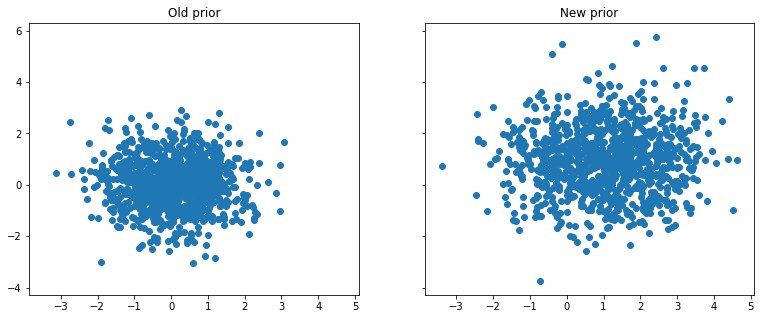

In [35]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

prior_new = mu_init + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [17]:
# q_new = q_init
# p_new = p_init

# print("Now we are running warmup!")
# iterator = tqdm(range(args.n_warmup // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, _, _ = our_kernel_best[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                    k=cond_vectors[k])
# iterator.close()
    
# samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
# print("Now we are sampling!")

# iterator = tqdm(range(args.n_steps // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, a, _ = our_kernel_best[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                        k=cond_vectors[k])
#         samples_our[i] = q_new.detach()
# iterator.close()

In [18]:
# target_samples = target.get_samples(n=1000).cpu().numpy()

# fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
# plt.suptitle('HMC our')
# for chain_num in range(args.n_chains):
#     ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
#     ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
#     ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_aspect('equal')
#     ax[chain_num // 5, chain_num % 5].legend()
# plt.tight_layout();
# plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

In [46]:
# n_samples = 10000
n_chains = 50
repetitions = 1

init_q = mu_init + args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True) * nn.functional.softplus(sigma_init)
q = init_q
our_samples = []
# our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
    for k in range(args.K):
        if args.amortize:
            q, p, _, _, _, _ = our_kernel_best.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        else:
            q, p, _, _, _, _ = our_kernel_best[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [47]:
our_samples = np.array(our_samples)

In [48]:
our_samples.shape

(20, 50, 2)

In [49]:
target_samples.shape

(1000, 2)

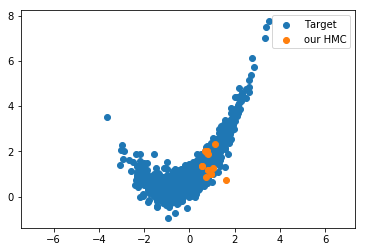

In [50]:
chain_ind = 11


plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(our_samples[:, chain_ind, 0], our_samples[:, chain_ind, 1], label='our HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();


# With reparam trick

In [51]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
    our_kernel_best = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    our_kernel_best = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
        
for p in transitions.parameters():
    transitions.requires_grad_(False)
    
mu_init = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))

params = list(transitions.parameters()) + list(reverse_params) + [mu_init, sigma_init]

optimizer = torch.optim.Adam(params=params)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)




















  0%|          | 0/5000 [00:00<?, ?it/s]

On batch number 0 and on k = 1 we have for 0: 0.518 and for +1: 0.482
Step size for 0-th transition is 0.09999999403953552
Alpha (ref) for 0-th transition is 0.5
On batch number 0 and on k = 2 we have for 0: 0.486 and for +1: 0.514
Step size for 1-th transition is 0.09999999403953552
Alpha (ref) for 1-th transition is 0.5
On batch number 0 and on k = 3 we have for 0: 0.55 and for +1: 0.45
Step size for 2-th transition is 0.09999999403953552
Alpha (ref) for 2-th transition is 0.5
On batch number 0 and on k = 4 we have for 0: 0.474 and for +1: 0.526
Step size for 3-th transition is 0.09999999403953552
Alpha (ref) for 3-th transition is 0.5
On batch number 0 and on k = 5 we have for 0: 0.498 and for +1: 0.502
Step size for 4-th transition is 0.09999999403953552
Alpha (ref) for 4-th transition is 0.5
On batch number 0 and on k = 6 we have for 0: 0.456 and for +1: 0.544
Step size for 5-th transition is 0.09999999403953552
Alpha (ref) for 5-th transition is 0.5
On batch number 0 and on k = 7

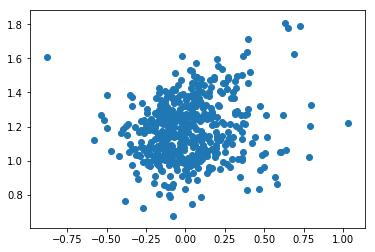

Current lr:  0.0008100000000000001
On batch number 0 ELBO is -21.785200119018555
On batch number 0 Best ELBO is -inf


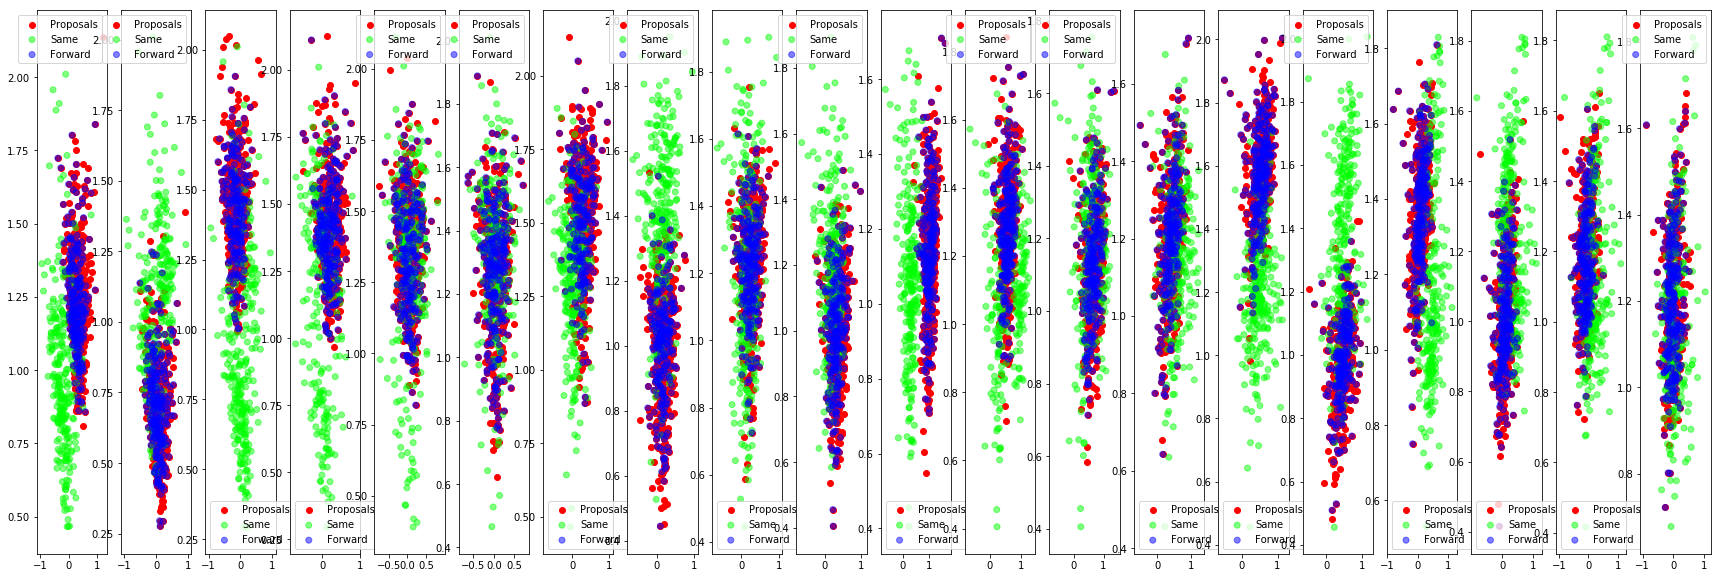

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [63]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(z, p, z_old, p_old, mu, sigma, current_log_alphas, log_jac):
    log_p = target.get_logdensity(z=z) + args.std_normal.log_prob(p).sum(1)
    log_r = -args.K * torch_log_2
    sum_log_sigma = torch.sum(torch.log(nn.functional.softplus(sigma)))
    log_m = args.std_normal.log_prob(z_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) -sum_log_sigma- log_jac + current_log_alphas
    elbo_full = log_p + log_r - log_m
    current_grad = torch.mean(elbo_full + current_log_alphas* (elbo_full.detach()))
    return elbo_full.detach().mean().item(), current_grad

iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
     # sample initial q and p
    u = args.std_normal.sample((args.train_batch_size, args.z_dim))
    q_old = mu_init + u * nn.functional.softplus(sigma_init)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
    # run training cycle
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        if (batch_num) % print_info_ == 0:
            print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
                                                        (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
            if args.amortize:
                print('Step size for {}-th transition is {}'.format(k, transitions.gamma.detach().exp()))
                print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions.alpha_logit.detach())))               
            else:
                print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
                print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))

        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        sum_log_alpha += current_log_alphas
        sum_log_jacobian += log_jac
        
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
        fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
        label = ['Same', 'Forward']
        for kk in range(args.K):
            ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
            for d in [0., 1.]:
                z_c = array_z[kk][array_directions[kk]==d]
                alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
                color = np.zeros((z_c.shape[0], 4))
                color[:, 3] = alpha_c
                color[:, int(d + 1)] = 1.
                ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
                ax[kk].legend()
        plt.show();
    elbo_full, grad_elbo = compute_loss(z=q, p=p, z_old=q_old, p_old=p_old,mu = mu_init, sigma = sigma_init,
                                current_log_alphas=sum_log_alpha, log_jac=sum_log_jacobian)    
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        #our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break